In [5]:
using POMDPs, POMDPGym, Crux, Distributions, BSON, GridInterpolations, LinearAlgebra
using BSON: @save
using StatsFuns
using Random
using PGFPlots

In [6]:
using Colors, ColorSchemes

In [8]:
resetPGFPlotsPreamble()

1-element Vector{Any}:
 "\\usepackage{pgfplots}\n\\pgfplots" ⋯ 105 bytes ⋯ "{arrows}\n\\tikzset{>=stealth'}\n"

In [9]:
include("/home/smkatz/Documents/Util/support_code.jl");

In [4]:
include("../../src/multilevel_estimation.jl")
include("../../src/montecarlo.jl")
include("../../src/gaussian_process.jl")
include("../../src/bandit.jl")
include("../../src/kernel_bandit.jl")
include("../../src/learning_bandit.jl")
include("../../src/pspec_bandit.jl")
include("controller.jl")
include("setup.jl")

pendulum_problem (generic function with 1 method)

# Load in Ground Truth

In [24]:
function pendulum_mc_model(nθ, nω, nsamps; σθ_max=0.3, σω_max=0.3)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return MonteCarloModel(grid, nsamps)
end

pendulum_mc_model (generic function with 1 method)

In [25]:
model_gt = BSON.load("results/ground_truth.bson")[:model]
# Fix for bug when ground truth was generated
model_gt.β = model_gt.nsamps .+ model_gt.β .- 1
problem_gt = pendulum_problem(101, 101, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt, model_gt)

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_gt_small = pendulum_mc_model(nθ, nω, 10000; σθ_max=σθ_max, σω_max=σω_max)

function fill_in_small(model_gt, model_gt_small)
    for ind in 1:length(model_gt_small.grid)
        x = ind2x(model_gt_small.grid, ind)
        ind_orig = interpolants(model_gt.grid, x)[1][1]
        model_gt_small.α[ind] = model_gt.α[ind_orig]
        model_gt_small.β[ind] = model_gt.β[ind_orig]
        model_gt_small.pfail[ind] = model_gt.pfail[ind_orig]
    end
end

fill_in_small(model_gt, model_gt_small)
problem_gt_small = pendulum_problem(nθ, nω, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt_small, model_gt_small)

# Plot Pfail Ground Truth

In [8]:
function get_heat(x, y, model)
    return interpolate(model.grid, model.pfail, [x, y])
end

function get_heat_2(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.pfail[sps[argmax(ps)]]
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_2(x, y, model_gt_small), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=1.0))
ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = L"$\hat P_\text{fail}(\eta)$"
ax1.width = "6cm"
ax1.height = "6cm"
# ax1

"6cm"

In [9]:
black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
colors = [white, green]
safe_map = ColorMaps.RGBArrayMap(colors)

function get_heat(x, y, problem)
    sps, ps = interpolants(problem.grid, [x, y])
    return problem.is_safe[sps[argmax(ps)]]
end

ax2 = Axis(Plots.Image((x, y) -> get_heat(x, y, problem_gt_small), (0.0, 0.2), (0.0, 1.0),
           (colormap = safe_map), colorbar=false, zmin=0.0, zmax=1.0))
ax2.xlabel = L"$\sigma_\theta$" 
ax2.ylabel = L"$\sigma_\omega$"#
ax2.title = "Safe Set Estimate"
ax2.width = "6cm"
ax2.height = "6cm"
# ax2

"6cm"

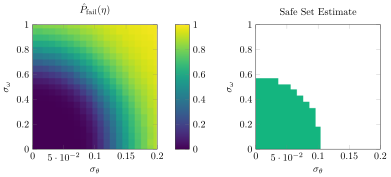

In [10]:
g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
#PGFPlots.save("ground_truth.tex", g, include_preamble=false)
g

# Gaussian Process Figures

In [95]:
w=[1.0, 0.04]
W = diagm(w ./ norm(w))

2×2 Matrix{Float64}:
 0.999201  0.0
 0.0       0.039968

In [88]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_gp_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, nsamps=500, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    # Set up the mean and kernel functions
    m(x) = zeros(length(x)) #0.5 * ones(length(x))
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    # Solve for variance based on coefficient of variation
    cv = √((1 - 0.1) / (0.1 * nsamps))
    ν = (0.1 * cv)^2

    return GaussianProcessModel(grid, nsamps, m, k, ν)
end

nsamps_tot = 20000
nsamps_indiv = 100

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

MILE_acquisition(model) = MILE_acquisition(model, problem.pfail_threshold, problem.conf_threshold)

# ss_gp = []
# for i = 1:5
#     model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
#     set_sizes_gp = run_estimation!(model_gp, problem, MILE_acquisition, nsamps_tot)
#     push!(ss_gp, set_sizes_gp)
# end

model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=5e-2)
run_estimation!(model_gp, problem, random_acquisition, 1000)

0.0%┣                                               ┫ 0/10 [00:00<00:-1, -0s/it]
10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:00<00:01, 6it/s]
30.0%┣██████████████                                 ┫ 3/10 [00:00<00:01, 8it/s]
40.0%┣██████████████████▍                           ┫ 4/10 [00:00<00:01, 10it/s]
50.0%┣███████████████████████                       ┫ 5/10 [00:00<00:00, 11it/s]
70.0%┣████████████████████████████████▏             ┫ 7/10 [00:00<00:00, 13it/s]
80.0%┣████████████████████████████████████▉         ┫ 8/10 [00:01<00:00, 12it/s]
90.0%┣█████████████████████████████████████████▍    ┫ 9/10 [00:01<00:00, 12it/s]
100.0%┣████████████████████████████████████████████┫ 10/10 [00:01<00:00, 12it/s]
100.0%┣████████████████████████████████████████████┫ 10/10 [00:01<00:00, 12it/s]


11-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

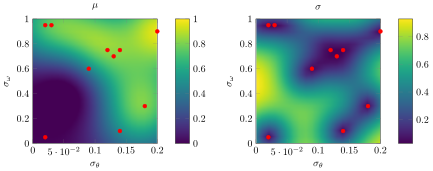

In [97]:
all_X = [X for X in model_gp.grid]
all_inds = collect(1:length(model_gp.grid))

μ, σ² = predict(model_gp, model_gp.X, model_gp.X_inds, model_gp.y, all_X, all_inds, model_gp.K)

function get_heat_mean(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return μ[sps[argmax(ps)]]
end

function get_heat_mean_2(x, y, model)
    return interpolate(model.grid, μ, [x, y])
end

function get_heat_variance(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return sqrt(σ²[sps[argmax(ps)]])
end

function get_heat_variance_2(x, y, model)
    return interpolate(model.grid, sqrt.(σ²), [x, y])
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_mean_2(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=1.0))
ax2 = Axis(Plots.Image((x, y) -> get_heat_variance_2(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true))
xs_eval = [ind2x(model_gp.grid, i)[1] for i in model_gp.X_inds]
ys_eval = [ind2x(model_gp.grid, i)[2] for i in model_gp.X_inds]
push!(ax1, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))
push!(ax2, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = L"$\mu$"
ax1.width = "6cm"
ax1.height = "6cm"

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = L"$\sigma$"
ax2.width = "6cm"
ax2.height = "6cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
# PGFPlots.save("gp_model.tex", g, include_preamble=false)
g

In [100]:
β = quantile(Normal(), 0.95)
test_stats = μ .+ β .* sqrt.(σ²)

function get_heat_test(x, y, model)
    return interpolate(model.grid, test_stats, [x, y])
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_test(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true))
ax2 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))
push!(ax1, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = "Test Statistic"
ax1.width = "6cm"
ax1.height = "6cm"

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = "Safe Set"
ax2.width = "6cm"
ax2.height = "6cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
PGFPlots.save("gp_safe_set.tex", g, include_preamble=false)
# g

In [102]:
0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0

(0.0392156862745098, 0.35490196078431374, 0.24901960784313726)

In [155]:
model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=5e-2)
run_estimation!(model_gp, problem, MILE_acquisition, 500)

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
20.0%┣████████▋                                  ┫ 1/5 [00:00<Inf:Inf, InfGs/it]
40.0%┣███████████████████▏                            ┫ 2/5 [00:00<00:01, 5it/s]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:00<00:00, 7it/s]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:00<00:00, 8it/s]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 8it/s]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 8it/s]


6-element Vector{Int64}:
 0
 0
 0
 1
 2
 2

In [156]:
all_X = [X for X in model_gp.grid]
all_inds = collect(1:length(model_gp.grid))

μ, σ² = predict(model_gp, model_gp.X, model_gp.X_inds, model_gp.y, all_X, all_inds, model_gp.K)

β = quantile(Normal(), 0.95)
test_stats = μ .+ β .* sqrt.(σ²)

function get_heat_test(x, y, model)
    return interpolate(model.grid, test_stats, [x, y])
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_test(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=2.0))
ax2 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))
xs_eval = [ind2x(model_gp.grid, i)[1] for i in model_gp.X_inds]
ys_eval = [ind2x(model_gp.grid, i)[2] for i in model_gp.X_inds]
push!(ax1, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = "Test Statistic"
ax1.width = "4cm"
ax1.height = "4cm"

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = "Safe Set"
ax2.width = "4cm"
ax2.height = "4cm"

# g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
# push!(g, ax1)
# push!(g, ax2)
# g

"4cm"

In [157]:
run_estimation!(model_gp, problem, MILE_acquisition, 500)

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
20.0%┣████████▋                                  ┫ 1/5 [00:00<Inf:Inf, InfGs/it]
40.0%┣███████████████████▏                            ┫ 2/5 [00:00<00:01, 4it/s]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:00<00:00, 5it/s]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:00<00:00, 6it/s]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 7it/s]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:01<00:00, 7it/s]


6-element Vector{Int64}:
  0
  2
  5
 13
 20
 32

In [158]:
all_X = [X for X in model_gp.grid]
all_inds = collect(1:length(model_gp.grid))

μ, σ² = predict(model_gp, model_gp.X, model_gp.X_inds, model_gp.y, all_X, all_inds, model_gp.K)

β = quantile(Normal(), 0.95)
test_stats = μ .+ β .* sqrt.(σ²)

function get_heat_test(x, y, model)
    return interpolate(model.grid, test_stats, [x, y])
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax3 = Axis(Plots.Image((x, y) -> get_heat_test(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=2.0))
ax4 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))
xs_eval = [ind2x(model_gp.grid, i)[1] for i in model_gp.X_inds]
ys_eval = [ind2x(model_gp.grid, i)[2] for i in model_gp.X_inds]
push!(ax3, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))

ax3.xlabel = L"$\sigma_\theta$"
ax3.ylabel = L"$\sigma_\omega$"
ax3.title = "Test Statistic"
ax3.width = "4cm"
ax3.height = "4cm"

ax4.xlabel = L"$\sigma_\theta$"
ax4.ylabel = L"$\sigma_\omega$"
ax4.title = "Safe Set"
ax4.width = "4cm"
ax4.height = "4cm"

# g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
# push!(g, ax1)
# push!(g, ax2)
# g

"4cm"

In [159]:
run_estimation!(model_gp, problem, MILE_acquisition, 4000)

0.0%┣                                               ┫ 0/40 [00:00<00:-2, -0s/it]
2.5%┣█                                          ┫ 1/40 [00:00<Inf:Inf, InfGs/it]
5.0%┣██▍                                             ┫ 2/40 [00:00<00:10, 4it/s]
7.5%┣███▋                                            ┫ 3/40 [00:00<00:07, 5it/s]
10.0%┣████▊                                          ┫ 4/40 [00:00<00:06, 6it/s]
12.5%┣█████▉                                         ┫ 5/40 [00:01<00:05, 7it/s]
15.0%┣███████                                        ┫ 6/40 [00:01<00:05, 7it/s]
17.5%┣████████▎                                      ┫ 7/40 [00:01<00:04, 8it/s]
20.0%┣█████████▍                                     ┫ 8/40 [00:01<00:04, 8it/s]
22.5%┣██████████▋                                    ┫ 9/40 [00:01<00:03, 9it/s]
25.0%┣███████████▌                                  ┫ 10/40 [00:01<00:03, 9it/s]
27.5%┣████████████▋                                 ┫ 11/40 [00:01<00:03, 9it/s]
30.0%┣█████████████▉        

41-element Vector{Int64}:
  0
 42
 49
 54
 64
 69
 77
 77
 77
 78
  ⋮
 95
 95
 95
 95
 95
 95
 95
 95
 95

In [160]:
all_X = [X for X in model_gp.grid]
all_inds = collect(1:length(model_gp.grid))

μ, σ² = predict(model_gp, model_gp.X, model_gp.X_inds, model_gp.y, all_X, all_inds, model_gp.K)

β = quantile(Normal(), 0.95)
test_stats = μ .+ β .* sqrt.(σ²)

function get_heat_test(x, y, model)
    return interpolate(model.grid, test_stats, [x, y])
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax5 = Axis(Plots.Image((x, y) -> get_heat_test(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=2.0))
ax6 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_gp), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))
xs_eval = [ind2x(model_gp.grid, i)[1] for i in model_gp.X_inds]
ys_eval = [ind2x(model_gp.grid, i)[2] for i in model_gp.X_inds]
push!(ax5, Plots.Scatter(xs_eval, ys_eval, mark="*", style="mark options={fill=red}"))

ax5.xlabel = L"$\sigma_\theta$"
ax5.ylabel = L"$\sigma_\omega$"
ax5.title = "Test Statistic"
ax5.width = "4cm"
ax5.height = "4cm"

ax6.xlabel = L"$\sigma_\theta$"
ax6.ylabel = L"$\sigma_\omega$"
ax6.title = "Safe Set"
ax6.width = "4cm"
ax6.height = "4cm"

# g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
# push!(g, ax1)
# push!(g, ax2)
# g

"4cm"

In [161]:
g = GroupPlot(3, 2, groupStyle="horizontal sep = 1.0cm, vertical sep = 2.0cm")
push!(g, ax1)
push!(g, ax3)
push!(g, ax5)
push!(g, ax2)
push!(g, ax4)
push!(g, ax6)
PGFPlots.save("gp_MILE.tex", g, include_preamble=false)
# g

In [162]:
5000 / (21 * 21 * 10000)

0.0011337868480725624

# Bandits

In [14]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
# dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold)
set_sizes_b = run_estimation!(model_b, problem, random_acquisition, 10000)

0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
0.9%┣▍                                         ┫ 85/10.0k [00:00<00:12, 824it/s]
1.6%┣▋                                       ┫ 162/10.0k [00:00<00:09, 1.1kit/s]
2.5%┣█                                       ┫ 246/10.0k [00:00<00:08, 1.2kit/s]
2.8%┣█                                       ┫ 277/10.0k [00:00<00:09, 1.1kit/s]
3.6%┣█▌                                      ┫ 365/10.0k [00:00<00:08, 1.2kit/s]
4.5%┣█▉                                      ┫ 447/10.0k [00:00<00:08, 1.3kit/s]
5.3%┣██▏                                     ┫ 530/10.0k [00:00<00:07, 1.3kit/s]
6.1%┣██▌                                     ┫ 614/10.0k [00:00<00:07, 1.3kit/s]
6.9%┣██▊                                     ┫ 694/10.0k [00:01<00:07, 1.4kit/s]
7.4%┣███                                     ┫ 741/10.0k [00:01<00:07, 1.3kit/s]
8.2%┣███▎                   

10001-element Vector{Int64}:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  ⋮
 24
 24
 24
 24
 24
 24
 24
 24
 24
 24
 24
 24

In [54]:
function get_heat_bandit(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    ind = sps[argmax(ps)]
    return model.α[ind] / (model.α[ind] + model.β[ind])
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_bandit(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=1.0))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = L"$\hat P_\text{fail}(\eta)$"
ax1.width = "6cm"
ax1.height = "6cm"

PGFPlots.save("bandit_model.tex", ax1)
# ax1

0.3026431198000003


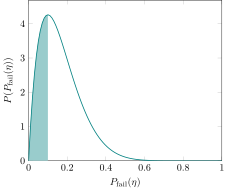

In [66]:
function plot_beta_dist(α, β; fill=false, threshold=0.1)
    dist = Beta(α, β)
    ax = Axis(Plots.Linear((x) -> pdf(dist, x), (0, 1), style="thick, teal"))
    if fill
        # push!(ax, Plots.Linear([threshold, threshold], [0.0, pdf(dist, threshold)],
        #                        style="draw=none, mark=none, name path=B, forget plot"))
        # push!(ax, Plots.Command("\\addplot[teal!40] fill between[of=A and B];"))
        push!(ax, Plots.Linear((x) -> pdf(dist, x), (0, threshold), 
                               style="draw=none, mark=none, name path=A, forget plot"))
        push!(ax, Plots.Linear([0.0, threshold], [0.0, 0.0], 
                               style="draw=none, mark=none, name path=B, forget plot"))
        push!(ax, Plots.Command("\\addplot[teal!40] fill between[of=A and B];"))
    end
    ax.xmin=0.0
    ax.xmax=1.0
    ax.ymin=0.0
    ax.xlabel=L"$P_\text{fail}(\eta)$"
    ax.ylabel=L"$P(P_\text{fail}(\eta))$"
    return ax
end

state = [0.08, 0.4]
sps, ps = interpolants(model_b.grid, state)
ind = sps[argmax(ps)]
ax = plot_beta_dist(model_b.α[ind], model_b.β[ind], fill=true)
println(cdf(Beta(model_b.α[ind], model_b.β[ind]), 0.1))
PGFPlots.save("beta_08_4_fill.tex", ax, include_preamble=false)
ax

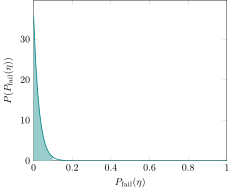

In [67]:
state = [0.02, 0.2]
sps, ps = interpolants(model_b.grid, state)
ind = sps[argmax(ps)]
ax = plot_beta_dist(model_b.α[ind], model_b.β[ind], fill=true)
PGFPlots.save("beta_02_2_fill.tex", ax, include_preamble=false)
ax

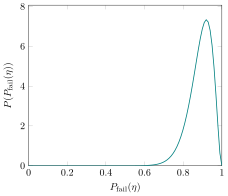

In [68]:
state = [0.15, 0.7]
sps, ps = interpolants(model_b.grid, state)
ind = sps[argmax(ps)]
ax = plot_beta_dist(model_b.α[ind], model_b.β[ind], fill=true)
PGFPlots.save("beta_15_7_fill.tex", ax, include_preamble=false)
ax

In [64]:
test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(model_b.α, model_b.β)]

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax4 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax4.xlabel = L"$\sigma_\theta$"
ax4.ylabel = L"$\sigma_\omega$"
ax4.title = "Safe Set"
ax4.width = "6cm"
ax4.height = "6cm"
PGFPlots.save("temp.tex", ax4, include_preamble=false)
# ax4

In [142]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold, rand_argmax=true)
set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 1000)

0.0%┣                                            ┫ 0/1.0k [00:00<00:-50, -0s/it]
0.1%┣                                         ┫ 1/1.0k [00:00<Inf:Inf, InfGs/it]
8.1%┣███▌                                       ┫ 81/1.0k [00:00<00:01, 790it/s]
15.9%┣██████▍                                 ┫ 159/1.0k [00:00<00:01, 1.0kit/s]
22.8%┣█████████▏                              ┫ 228/1.0k [00:00<00:01, 1.1kit/s]
29.4%┣███████████▊                            ┫ 294/1.0k [00:00<00:01, 1.2kit/s]
34.1%┣█████████████▋                          ┫ 341/1.0k [00:00<00:01, 1.1kit/s]
40.9%┣████████████████▍                       ┫ 409/1.0k [00:00<00:01, 1.1kit/s]
46.6%┣██████████████████▋                     ┫ 466/1.0k [00:00<00:00, 1.1kit/s]
52.1%┣████████████████████▉                   ┫ 521/1.0k [00:00<00:00, 1.1kit/s]
57.6%┣███████████████████████                 ┫ 576/1.0k [00:01<00:00, 1.1kit/s]
63.0%┣█████████████████████████▏              ┫ 630/1.0k [00:01<00:00, 1.1kit/s]
65.1%┣██████████████████████

1001-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 7
 7
 7
 7
 7
 7
 7
 7
 7
 7
 7
 7

In [143]:
test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(model_b.α, model_b.β)]
other_test_stats = [cdf(Beta(α, β), 0.1) for (α, β) in zip(model_b.α, model_b.β)]

function get_heat_neps(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.α[sps[argmax(ps)]] + model.β[sps[argmax(ps)]] - 2
end

function get_test_stats(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return test_stats[sps[argmax(ps)]]
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax5 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=1.0))
ax6 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax5.xlabel = L"$\sigma_\theta$"
ax5.ylabel = L"$\sigma_\omega$"
ax5.title = "Test Statistic"
ax5.width = "4cm"
ax5.height = "4cm"

ax6.xlabel = L"$\sigma_\theta$"
ax6.ylabel = L"$\sigma_\omega$"
ax6.title = "Safe Set"
ax6.width = "4cm"
ax6.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax5)
push!(g, ax6)
PGFPlots.save("temp.tex", g)
# g

In [144]:
set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 1000)

0.0%┣                                            ┫ 0/1.0k [00:00<00:-50, -0s/it]
0.1%┣                                         ┫ 1/1.0k [00:00<Inf:Inf, InfGs/it]
1.7%┣▊                                          ┫ 17/1.0k [00:00<00:07, 150it/s]
6.6%┣██▉                                        ┫ 66/1.0k [00:00<00:02, 413it/s]
11.9%┣████▉                                    ┫ 119/1.0k [00:00<00:02, 568it/s]
17.1%┣███████                                  ┫ 171/1.0k [00:00<00:01, 657it/s]
19.2%┣███████▉                                 ┫ 192/1.0k [00:00<00:01, 617it/s]
24.8%┣██████████▏                              ┫ 248/1.0k [00:00<00:01, 687it/s]
30.0%┣████████████▎                            ┫ 300/1.0k [00:00<00:01, 729it/s]
35.2%┣██████████████▍                          ┫ 352/1.0k [00:00<00:01, 763it/s]
40.4%┣████████████████▋                        ┫ 404/1.0k [00:01<00:01, 790it/s]
45.5%┣██████████████████▋                      ┫ 455/1.0k [00:01<00:01, 810it/s]
47.4%┣███████████████████▍  

1001-element Vector{Int64}:
  0
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7
  ⋮
 40
 40
 40
 40
 40
 40
 40
 40
 40
 41
 41
 41

In [145]:
test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(model_b.α, model_b.β)]
other_test_stats = [cdf(Beta(α, β), 0.1) for (α, β) in zip(model_b.α, model_b.β)]

function get_heat_neps(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.α[sps[argmax(ps)]] + model.β[sps[argmax(ps)]] - 2
end

function get_test_stats(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return test_stats[sps[argmax(ps)]]
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax5 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false))
ax6 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax5.xlabel = L"$\sigma_\theta$"
ax5.ylabel = L"$\sigma_\omega$"
ax5.title = "Test Statistic"
ax5.width = "4cm"
ax5.height = "4cm"

ax6.xlabel = L"$\sigma_\theta$"
ax6.ylabel = L"$\sigma_\omega$"
ax6.title = "Safe Set"
ax6.width = "4cm"
ax6.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax5)
push!(g, ax6)
PGFPlots.save("temp.tex", g)
# g

In [146]:
set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 3000)

0.0%┣                                            ┫ 0/3.0k [00:00<-2:-30, -0s/it]
0.0%┣                                         ┫ 1/3.0k [00:00<Inf:Inf, InfGs/it]
0.7%┣▎                                          ┫ 21/3.0k [00:00<00:20, 145it/s]
2.7%┣█▏                                         ┫ 80/3.0k [00:00<00:07, 419it/s]
4.5%┣█▉                                        ┫ 134/3.0k [00:00<00:05, 557it/s]
6.2%┣██▋                                       ┫ 187/3.0k [00:00<00:04, 643it/s]
8.0%┣███▍                                      ┫ 240/3.0k [00:00<00:04, 704it/s]
9.7%┣████                                      ┫ 292/3.0k [00:00<00:04, 746it/s]
10.8%┣████▍                                    ┫ 323/3.0k [00:00<00:04, 713it/s]
12.7%┣█████▏                                   ┫ 381/3.0k [00:01<00:03, 756it/s]
14.5%┣██████                                   ┫ 436/3.0k [00:01<00:03, 786it/s]
16.3%┣██████▊                                  ┫ 490/3.0k [00:01<00:03, 810it/s]
18.1%┣███████▍              

3001-element Vector{Int64}:
  0
 41
 41
 41
 41
 41
 41
 41
 41
 41
 41
 41
 41
  ⋮
 89
 89
 89
 89
 89
 89
 89
 89
 89
 89
 89
 89

In [147]:
test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(model_b.α, model_b.β)]
other_test_stats = [cdf(Beta(α, β), 0.1) for (α, β) in zip(model_b.α, model_b.β)]

function get_heat_neps(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.α[sps[argmax(ps)]] + model.β[sps[argmax(ps)]] - 2
end

function get_test_stats(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return test_stats[sps[argmax(ps)]]
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax5 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false))
ax6 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax5.xlabel = L"$\sigma_\theta$"
ax5.ylabel = L"$\sigma_\omega$"
ax5.title = "Test Statistic"
ax5.width = "4cm"
ax5.height = "4cm"

ax6.xlabel = L"$\sigma_\theta$"
ax6.ylabel = L"$\sigma_\omega$"
ax6.title = "Safe Set"
ax6.width = "4cm"
ax6.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax5)
push!(g, ax6)
PGFPlots.save("temp.tex", g)
# g

# Smoothing Bandits

In [10]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
# dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold)
set_sizes_b = run_estimation!(model_b, problem, random_acquisition, 10000)

0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:07<Inf:Inf, InfGs/it]
0.0%┣                                          ┫ 2/10.0k [00:07<18:39:11, 7s/it]
1.0%┣▍                                         ┫ 102/10.0k [00:07<11:03, 15it/s]
1.9%┣▉                                         ┫ 187/10.0k [00:07<06:00, 27it/s]
2.7%┣█▏                                        ┫ 268/10.0k [00:07<04:10, 39it/s]
3.6%┣█▌                                        ┫ 357/10.0k [00:07<03:07, 51it/s]
4.3%┣█▉                                        ┫ 430/10.0k [00:07<02:35, 62it/s]
4.7%┣██                                        ┫ 466/10.0k [00:07<02:24, 66it/s]
5.5%┣██▎                                       ┫ 554/10.0k [00:07<02:01, 78it/s]
6.3%┣██▋                                       ┫ 632/10.0k [00:07<01:46, 89it/s]
7.1%┣███                                       ┫ 711/10.0k [00:07<01:34, 99it/s]
7.7%┣███▏                   

10001-element Vector{Int64}:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  ⋮
 18
 18
 18
 18
 18
 18
 18
 18
 18
 18
 18
 18

In [22]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function get_heat_counts(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.α[sps[argmax(ps)]] + model.β[sps[argmax(ps)]] - 2
end

w = [1.0, 0.04]
W = diagm(w ./ norm(w))

function get_heat_smoothed(x, y, model, ℓ=2e-2)
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)
    K = [k([x, y], pt) for pt in model.grid]
    wₖ = K' * (model.α .- 1)
    ℓₖ = K' * (model.β .- 1)
    return wₖ + ℓₖ
end

function get_heat_pfail(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.α[sps[argmax(ps)]] / (model.α[sps[argmax(ps)]] + model.β[sps[argmax(ps)]])
end

function get_heat_pfail_smoothed(x, y, model, ℓ=2e-2)
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)
    K = [k([x, y], pt) for pt in model.grid]
    αₖ = 1 .+ K' * (model.α .- 1)
    βₖ = 1 .+ K' * (model.β .- 1)
    return αₖ / (αₖ + βₖ)
end

ax1 = Axis(Plots.Image((x, y) -> get_heat_pfail(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
           (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=1.0))
ax2 = Axis(Plots.Image((x, y) -> get_heat_pfail_smoothed(x, y, model_b), (0.0, 0.2), (0.0, 1.0),
            (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=1.0))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = L"$\hat P_\text{fail}(\eta)$"
ax1.width = "6cm"
ax1.height = "6cm"

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = L"Smoothed $\hat P_\text{fail}(\eta)$"
ax2.width = "6cm"
ax2.height = "6cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 1.2cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
# PGFPlots.save("smoothed_pfail.tex", g)
g

In [23]:
function pendulum_kernel_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)
    return KernelBanditModel(grid, k)
end

pendulum_kernel_bandit_model (generic function with 1 method)

In [26]:
model_k = pendulum_kernel_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, ℓ=2e-2)
run_estimation!(model_k, problem, random_acquisition, 1000, tuple_return=true)

LoadError: MethodError: no method matching KernelBanditModel(::RectangleGrid{2}, ::var"#k#272"{Float64, Matrix{Float64}})
[0mClosest candidates are:
[0m  KernelBanditModel(::Any, ::Any, [91m::Any[39m; ℓmin, ℓmax, nbins, ℓconf) at ~/Documents/MultilevelEstimation/src/kernel_bandit.jl:25
[0m  KernelBanditModel(::Any; ℓmin, ℓmax, nbins, ℓconf) at ~/Documents/MultilevelEstimation/src/kernel_bandit.jl:36